In [253]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, MaxPool2D, Dropout
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.optimizers import Adagrad, Adam
from sklearn.metrics import classification_report
from tensorflow.keras.losses import CategoricalCrossentropy
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import sobel
import cv2
from scipy.ndimage import sobel as sobel2
from matplotlib import pyplot

In [90]:
output_train_dir = "./data_processed/train"
input_train_dir = "./data/train"
img_width, img_height = 100, 100

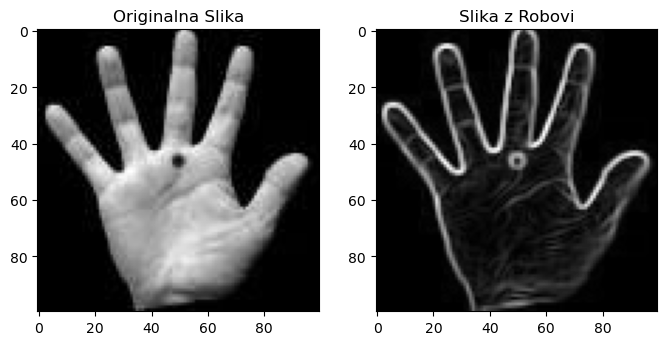

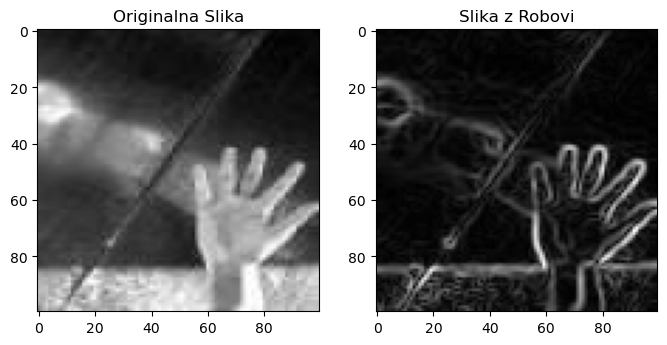

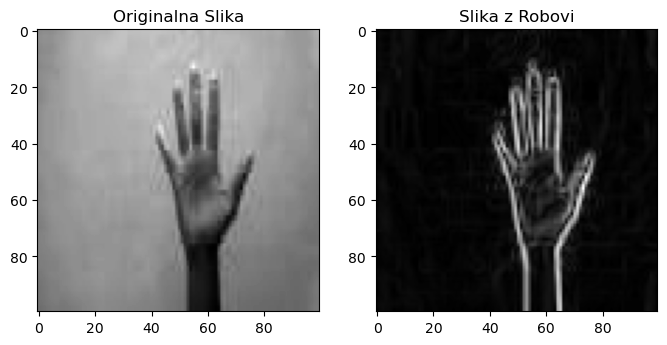

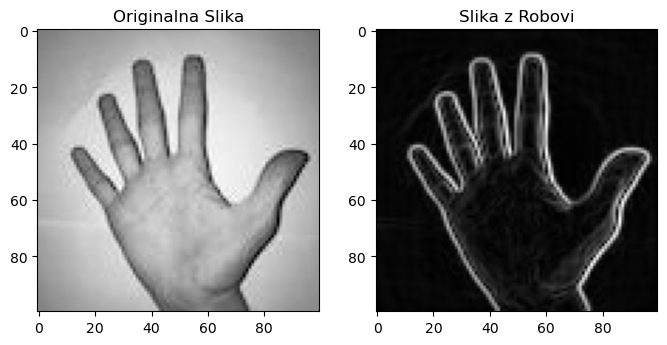

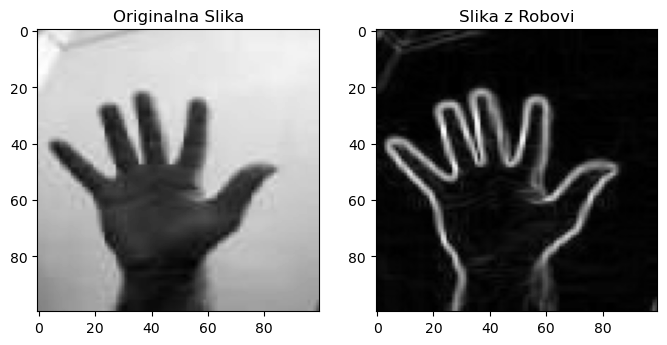

In [95]:
index = 0
max = 5

def process_and_save_image(input_path, output_path):
    img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_width, img_height), interpolation=cv2.INTER_AREA)

    global index
    global max
    if index < max:
      plt.figure(figsize=(8, 4))
      plt.subplot(1, 2, 1)
      plt.imshow(img, cmap='gray')
      plt.title('Originalna Slika')

    img_sobel = sobel(img)
    pyplot.imsave(output_path, img_sobel, cmap='gray')

    if index < max:
      plt.subplot(1, 2, 2)
      plt.imshow(img_sobel, cmap='gray')
      plt.title('Slika z Robovi')

    index = index + 1
# Obdelaj in shrani slike
for root, dirs, files in os.walk(input_train_dir):
    for subdir in dirs:
        input_class_path = os.path.join(input_train_dir, subdir)
        output_class_path = os.path.join(output_train_dir, subdir)  # Spremenjena pot za shranjevanje obdelanih slik
        os.makedirs(output_class_path, exist_ok=True)  # Ustvari mapo, če še ne obstaja

        for img_name in os.listdir(input_class_path):
            input_img_path = os.path.join(input_class_path, img_name)
            output_img_path = os.path.join(output_class_path, img_name)
            process_and_save_image(input_img_path, output_img_path)

In [81]:
input_test_dir = "./data/test"
output_test_dir = "./data_processed/test"

os.makedirs(output_test_dir, exist_ok=True)  # Ustvari mapo za izhodne slike, če še ne obstaja

for img_name in os.listdir(input_test_dir):
    input_img_path = os.path.join(input_test_dir, img_name)
    output_img_path = os.path.join(output_test_dir, img_name)
    process_and_save_image(input_img_path, output_img_path)

In [4]:
def create_train_dataframe(directory):
    filepaths = []
    labels = []

    for class_label in os.listdir(directory):
        class_path = os.path.join(directory, class_label)

        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                filepath = os.path.join(class_path, filename)
                filepaths.append(filepath)
                labels.append(class_label)

    df = pd.DataFrame({'filepath': filepaths, 'label': labels})
    return df

In [5]:
def create_test_dataframe(folder_path, label = 'test'):
    filepaths = []
    labels = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):  # Prilagodite razširitev datoteke, če so slike v drugem formatu
            filepath = os.path.join(folder_path, filename)
            filepaths.append(filepath)
            labels.append(label)

    df = pd.DataFrame({"filepath": filepaths, "label": labels})
    return df

In [235]:
train_folder = "./data/train"
test_folder = "./data/test"

train_df = create_train_dataframe(train_folder)

test_df = create_test_dataframe(test_folder)

print("Train DataFrame:")
print(train_df.head())

print("\nTest DataFrame:")
print(test_df.head())

Train DataFrame:
                            filepath  label
0     ./data/train\Paper\image_0.jpg  Paper
1     ./data/train\Paper\image_1.jpg  Paper
2    ./data/train\Paper\image_10.jpg  Paper
3   ./data/train\Paper\image_100.jpg  Paper
4  ./data/train\Paper\image_1000.jpg  Paper

Test DataFrame:
                          filepath label
0     ./data/test\test_image_0.jpg  test
1     ./data/test\test_image_1.jpg  test
2    ./data/test\test_image_10.jpg  test
3   ./data/test\test_image_100.jpg  test
4  ./data/test\test_image_1000.jpg  test


In [236]:
img_height = 100
img_width = 100
batch_size = 32

In [245]:
def create_cnn_model():
    model = Sequential()
    
    # Konvolucijska plast 1
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)))
    model.add(MaxPooling2D((2, 2)))
    
    # Konvolucijska plast 2
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    # Konvolucijska plast 3
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
     # Konvolucijska plast 4
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
      # Konvolucijska plast 4
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    # Sploščenje vektorja za polno povezane plasti
    model.add(Flatten())
    
    # Polno povezane plasti
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    # Izhodna plast s številom razredov (v tem primeru 3 razredi)
    model.add(Dense(3, activation='softmax'))
    
    # Kompilacija modela
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    
    return model


In [237]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.25,
    height_shift_range=0.25,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(
    rescale=1./255,
)

In [238]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath", # Ime stolpca z potmi do slik v DataFrame df_train
    y_col="label", # Ime stolpca z oznakami v DataFrame df_train
    subset="training",    # Tip množice (training za učno množico)
    batch_size=batch_size,        # Velikost paketa (batch size)
    target_size=(img_height, img_width), # Velikost ciljne slike
    shuffle=True,
    seed=1234,
    color_mode='grayscale'
)

validation_generator = train_datagen.flow_from_dataframe(
  dataframe=train_df,
  x_col="filepath", # Ime stolpca z potmi do slik v DataFrame df_train
  y_col="label", # Ime stolpca z oznakami v DataFrame df_train
  subset="validation",  # Tip množice (validation za validacijsko množico)
  batch_size=batch_size,        # Velikost paketa (batch size)
  target_size=(img_height, img_width), # Velikost ciljne slike
  shuffle=True,
  seed=1234,
  color_mode='grayscale'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath", # Ime stolpca z potmi do slik v DataFrame df_train
    y_col="label", # Ime stolpca z oznakami v DataFrame df_train
    batch_size=1,        # Velikost paketa (batch size)
    target_size=(img_height, img_width), # Velikost ciljne slike
    shuffle=False,
    color_mode='grayscale'
)

Found 2520 validated image filenames belonging to 3 classes.
Found 630 validated image filenames belonging to 3 classes.
Found 1350 validated image filenames belonging to 1 classes.


In [246]:
model = create_cnn_model()

history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator
)

Epoch 1/100
79/79 [==============================] - 19s 223ms/step - loss: 1.0324 - accuracy: 0.4123 - val_loss: 1.5689 - val_accuracy: 0.0000e+00
Epoch 2/100
79/79 [==============================] - 20s 255ms/step - loss: 1.0161 - accuracy: 0.4500 - val_loss: 1.8726 - val_accuracy: 0.0000e+00
Epoch 3/100
79/79 [==============================] - 20s 258ms/step - loss: 0.8986 - accuracy: 0.5984 - val_loss: 1.9309 - val_accuracy: 0.0000e+00
Epoch 4/100
79/79 [==============================] - 21s 266ms/step - loss: 0.7398 - accuracy: 0.6877 - val_loss: 1.4501 - val_accuracy: 0.0603
Epoch 5/100
79/79 [==============================] - 20s 249ms/step - loss: 0.6449 - accuracy: 0.7405 - val_loss: 1.4802 - val_accuracy: 0.0905
Epoch 6/100
79/79 [==============================] - 20s 247ms/step - loss: 0.5380 - accuracy: 0.7861 - val_loss: 0.8705 - val_accuracy: 0.6190
Epoch 7/100
79/79 [==============================] - 20s 248ms/step - loss: 0.4055 - accuracy: 0.8488 - val_loss: 0.7120 - v

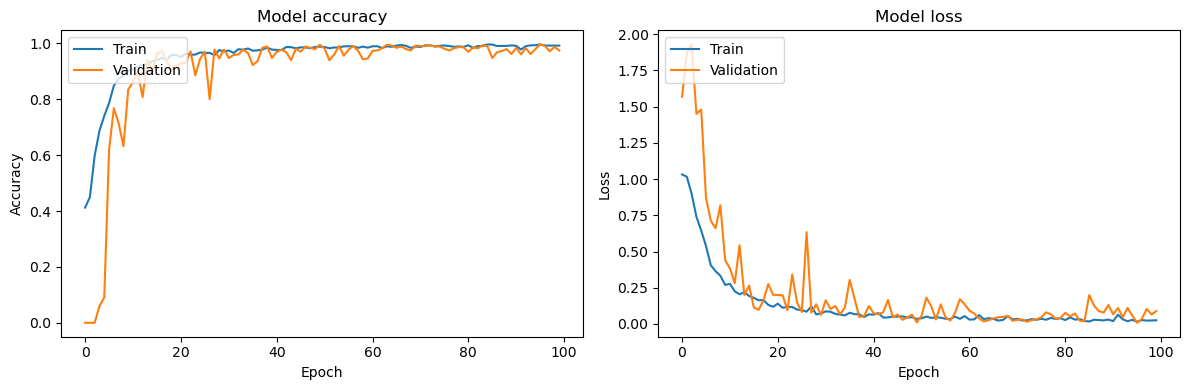

In [247]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [248]:
y_pred = model.predict(test_generator)

1350/1350 [==============================] - 14s 11ms/step


In [249]:
y_pred_classes = np.argmax(y_pred, axis=1)
class_indices_list = list(train_generator.class_indices.keys())
y_pred_classes = [class_indices_list[i] for i in y_pred_classes]

In [250]:
data = {'image': test_df['filepath'].apply(lambda x: os.path.basename(x)), 'predicted_class': y_pred_classes}
df = pd.DataFrame(data=data)
df.to_csv('output/submission-custom-nn-4.csv', index=False)

In [252]:
model.save('models/cnn-4.h5')

In [251]:
df1 = pd.read_csv('output/submission-custom-nn-3.csv')

# Preberi drugo CSV datoteko v dataframe
df2 = pd.read_csv('output/submission-custom-nn-4.csv')

# Združi dataframa glede na stolpec 'image_path'
merged_df = pd.merge(df1, df2, on='image', suffixes=('_1', '_2'))

# Izberi vrstice, kjer se predicted_class razlikuje med datotekama
differences = merged_df[merged_df['predicted_class_1'] != merged_df['predicted_class_2']]

if not differences.empty:
    print("Poti slik, kjer se predicted_class razlikujejo:")
    for index, row in differences.iterrows():
        print(f"Pot slike: {row['image']}")
        print(f"Napovedan razred datoteke 1: {row['predicted_class_1']}")
        print(f"Napovedan razred datoteke 2: {row['predicted_class_2']}")
        print()
else:
    print("V obeh datotekah so enaki predicted_class za vse slike.")

Poti slik, kjer se predicted_class razlikujejo:
Pot slike: test_image_1108.jpg
Napovedan razred datoteke 1: Scissors
Napovedan razred datoteke 2: Paper

Pot slike: test_image_1210.jpg
Napovedan razred datoteke 1: Scissors
Napovedan razred datoteke 2: Rock

Pot slike: test_image_356.jpg
Napovedan razred datoteke 1: Rock
Napovedan razred datoteke 2: Scissors

Pot slike: test_image_381.jpg
Napovedan razred datoteke 1: Scissors
Napovedan razred datoteke 2: Rock

Pot slike: test_image_56.jpg
Napovedan razred datoteke 1: Scissors
Napovedan razred datoteke 2: Paper

Pot slike: test_image_629.jpg
Napovedan razred datoteke 1: Paper
Napovedan razred datoteke 2: Rock

Pot slike: test_image_683.jpg
Napovedan razred datoteke 1: Paper
Napovedan razred datoteke 2: Scissors

Pot slike: test_image_906.jpg
Napovedan razred datoteke 1: Paper
Napovedan razred datoteke 2: Scissors


In [213]:
output_train_dir = "./data_processed_blured/train"
input_train_dir = "./data/train"
img_width, img_height = 100, 100

def blur_and_save_image(input_path, output_path): 
    img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)

    width, height = img.shape
    center_x, center_y = int(width / 2), int(height / 2)
    
    radius_array = [30, 40, 50, 60]
    
    out = img
    
    for i, radius in enumerate(radius_array):
        blurred_img = cv2.GaussianBlur(img, (21, 21), (i + 1) * 2)
                    
        mask = np.zeros((width, height), dtype=np.uint8)  # Masko ustvari kot črno-belo sliko
        mask = cv2.circle(mask, (center_y, center_x), radius, 255, -1)  # Ustvari krog v maski
    
    
        out = np.where(mask == 255, out, blurred_img)  # Uporabi masko za združevanje originalne in zamegljene slike
    
    out = cv2.resize(out, (img_width, img_height), interpolation=cv2.INTER_AREA)
    pyplot.imsave(output_path, out, cmap='gray')


for root, dirs, files in os.walk(input_train_dir):
    for subdir in dirs:
        input_class_path = os.path.join(input_train_dir, subdir)
        output_class_path = os.path.join(output_train_dir, subdir)  # Spremenjena pot za shranjevanje obdelanih slik
        os.makedirs(output_class_path, exist_ok=True)  # Ustvari mapo, če še ne obstaja

        for img_name in os.listdir(input_class_path):
            input_img_path = os.path.join(input_class_path, img_name)
            output_img_path = os.path.join(output_class_path, img_name)
            blur_and_save_image(input_img_path, output_img_path)

In [214]:
input_test_dir = "./data/test"
output_test_dir = "./data_processed_blured/test"

os.makedirs(output_test_dir, exist_ok=True)  # Ustvari mapo za izhodne slike, če še ne obstaja

for img_name in os.listdir(input_test_dir):
    input_img_path = os.path.join(input_test_dir, img_name)
    output_img_path = os.path.join(output_test_dir, img_name)
    blur_and_save_image(input_img_path, output_img_path)

In [254]:
model = load_model('models/cnn-4.h5')

In [255]:
y_pred = model.predict(test_generator)

1350/1350 [==============================] - 13s 9ms/step


In [256]:
y_pred_classes = np.argmax(y_pred, axis=1)
class_indices_list = list(train_generator.class_indices.keys())
y_pred_classes = [class_indices_list[i] for i in y_pred_classes]

In [257]:
data = {'image': test_df['filepath'].apply(lambda x: os.path.basename(x)), 'predicted_class': y_pred_classes}
df = pd.DataFrame(data=data)
df.to_csv('output/submission-custom-nn-test.csv', index=False)

In [258]:
df1 = pd.read_csv('output/submission-custom-nn-4.csv')

# Preberi drugo CSV datoteko v dataframe
df2 = pd.read_csv('output/submission-custom-nn-test.csv')

# Združi dataframa glede na stolpec 'image_path'
merged_df = pd.merge(df1, df2, on='image', suffixes=('_1', '_2'))

# Izberi vrstice, kjer se predicted_class razlikuje med datotekama
differences = merged_df[merged_df['predicted_class_1'] != merged_df['predicted_class_2']]

if not differences.empty:
    print("Poti slik, kjer se predicted_class razlikujejo:")
    for index, row in differences.iterrows():
        print(f"Pot slike: {row['image']}")
        print(f"Napovedan razred datoteke 1: {row['predicted_class_1']}")
        print(f"Napovedan razred datoteke 2: {row['predicted_class_2']}")
        print()
else:
    print("V obeh datotekah so enaki predicted_class za vse slike.")

V obeh datotekah so enaki predicted_class za vse slike.
